## Test ML models
### h2o.ai
Transform netCDF serialized files to h2o dataframes via xarray and pandas.

In [1]:
from dask.distributed import Client
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:40524 Dashboard: http://127.0.0.1:57090/status,Cluster Workers: 8 Cores: 24 Memory: 33.55 GB


In [3]:
client.close()

In [1]:
# Load data
import sys
sys.path.append('../b_Temporal_Stack')
import regionstack
import eotempstack

In [2]:
saldana = regionstack.regionStack('Saldana_training_2015')

S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Creation of new S1 stacks failed, reading existing stacks
Reading 8 S1 stack files
S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Creation of new S1 stacks failed, reading existing stacks
Reading 6 S1 stack files
S2 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Reading 6 S2 stack files
LE07 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Reading 4 LE07 stack files
LC08 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asala

In [3]:
saldana.S2

<xarray.Dataset>
Dimensions:  (time: 8, x: 2979, y: 3631)
Coordinates:
  * time     (time) datetime64[ns] 2015-12-11 2015-12-21 2015-12-31 ...
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y        (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
    mask     (time, y, x) int8 dask.array<shape=(8, 3631, 2979), chunksize=(1, 1000, 1000)>
Data variables:
    blue     (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    swir1    (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    swir2    (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    green    (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    nir      (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    NDVI     (time, y, x) float32 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    LSWI     (time, y, x) 

In [6]:
saldana.calcTempVariation('S2', ['NDVI','LSWI'])#,'red', 'green','blue','nir','swir1','swir2'])

Processing band NDVI for date 2015-12-21T00:00:00.000000000
Processing band NDVI for date 2015-12-31T00:00:00.000000000
Processing band NDVI for date 2016-01-10T00:00:00.000000000
Processing band NDVI for date 2016-01-20T00:00:00.000000000
Processing band NDVI for date 2016-01-30T00:00:00.000000000
Processing band NDVI for date 2016-02-09T00:00:00.000000000
Processing band NDVI for date 2016-02-19T00:00:00.000000000
Processing band LSWI for date 2015-12-21T00:00:00.000000000
Processing band LSWI for date 2015-12-31T00:00:00.000000000
Processing band LSWI for date 2016-01-10T00:00:00.000000000
Processing band LSWI for date 2016-01-20T00:00:00.000000000
Processing band LSWI for date 2016-01-30T00:00:00.000000000
Processing band LSWI for date 2016-02-09T00:00:00.000000000
Processing band LSWI for date 2016-02-19T00:00:00.000000000


In [12]:
saldana.calcTempVariation('S1_ASCENDING', ['VV'])
saldana.calcTempVariation('S1_DESCENDING', ['VV','VH'])
#saldana.S1_ASCENDING #[['NDVI_c','LSWI_c']]

Processing band VV for date 2015-12-21T00:00:00.000000000
Processing band VV for date 2016-01-14T00:00:00.000000000
Processing band VV for date 2016-02-07T00:00:00.000000000
Processing band VV for date 2015-12-28T00:00:00.000000000
Processing band VV for date 2016-01-21T00:00:00.000000000
Processing band VV for date 2016-02-14T00:00:00.000000000
Processing band VH for date 2015-12-28T00:00:00.000000000
Processing band VH for date 2016-01-21T00:00:00.000000000
Processing band VH for date 2016-02-14T00:00:00.000000000


In [17]:
ratio = saldana.S1_DESCENDING.VV / saldana.S1_DESCENDING.VH

In [3]:
shp_file = '/home/azalazar/data/saldana.shp'

saldana.regionTrainingClasses(shp_file, testset=0.3)

Adding dataset with classes as class_ds attribute of regionStack


In [4]:
saldana.class_ds

<xarray.Dataset>
Dimensions:  (time: 19, x: 2979, y: 3631)
Coordinates:
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * y        (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
  * time     (time) datetime64[ns] 2015-11-20 2015-11-27 2015-11-28 ...
Data variables:
    train    (time, y, x) uint8 dask.array<shape=(19, 3631, 2979), chunksize=(1, 3631, 2979)>
    test     (time, y, x) uint8 dask.array<shape=(19, 3631, 2979), chunksize=(1, 3631, 2979)>

In [6]:
saldana.train.to_netcdf(saldana.data_directory+'train.nc')#, chunks={'time':1})

In [21]:
client

Client Scheduler: tcp://127.0.0.1:41298 Dashboard: http://127.0.0.1:55865/status,Cluster Workers: 4 Cores: 24 Memory: 33.55 GB


In [27]:
t_dir = '/mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/'
train_data = xr.open_mfdataset(t_dir+'train.nc', chunks={'time':1, 'x':1000,'y':1220})
train_data

<xarray.Dataset>
Dimensions:   (time: 4, x: 2981, y: 3635)
Coordinates:
  * y         (y) float64 4.122e+05 4.122e+05 4.122e+05 4.122e+05 4.122e+05 ...
  * x         (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * time      (time) datetime64[ns] 2015-12-11 2015-12-21 2015-12-31 2016-01-10
    mask      (time, x, y) bool dask.array<shape=(4, 2981, 3635), chunksize=(1, 1000, 1220)>
Data variables:
    NDVI      (time, x, y) float32 dask.array<shape=(4, 2981, 3635), chunksize=(1, 1000, 1220)>
    LSWI      (time, x, y) float32 dask.array<shape=(4, 2981, 3635), chunksize=(1, 1000, 1220)>
    VV_ASC    (time, x, y) float32 dask.array<shape=(4, 2981, 3635), chunksize=(1, 1000, 1220)>
    VV_DSC    (time, x, y) float32 dask.array<shape=(4, 2981, 3635), chunksize=(1, 1000, 1220)>
    VH_DSC    (time, x, y) float32 dask.array<shape=(4, 2981, 3635), chunksize=(1, 1000, 1220)>
    train     (time, x, y) float64 dask.array<shape=(4, 2981, 3635), chunksize=(1, 1000, 1220)>
   

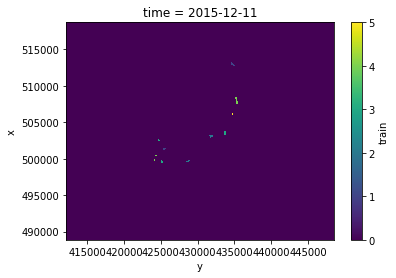

In [18]:
train_data.train.isel(time=0).plot()

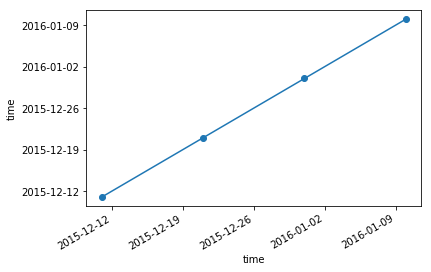

In [37]:
saldana.train.time.plot(marker='o')

In [34]:
import h2o

In [35]:
# Initialize h2o cluster
h2o.init(nthreads = -1, max_mem_size = 8)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-linux64) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-linux64) (build 25.121-b15, mixed mode)
  Starting server from /home/azalazar/anaconda3/envs/models3/h2o_jar/h2o.jar
  Ice root: /tmp/tmpu493eakk
  JVM stdout: /tmp/tmpu493eakk/h2o_azalazar_started_from_python.out
  JVM stderr: /tmp/tmpu493eakk/h2o_azalazar_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,07 secs
H2O cluster timezone:,America/Bogota
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,2 months and 25 days
H2O cluster name:,H2O_from_python_azalazar_mzv5cg
H2O cluster total nodes:,1
H2O cluster free memory:,7.111 Gb
H2O cluster total cores:,24
H2O cluster allowed cores:,24
H2O cluster status:,"accepting new members, healthy"


In [28]:
# Select only data from a date and transform to pandas dataframe
data_pd = train_data.to_dask_dataframe()

In [29]:
data_pd

,time,x,y,mask,NDVI,LSWI,VV_ASC,VV_DSC,VH_DSC,train,test,NDVI_c,LSWI_c,VV_ASC_c,VV_DSC_c,VH_DSC_c
npartitions=4,,,,,,,,,,,,,,,,
0,datetime64[ns],float64,float64,bool,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
10835935,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21671870,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32507805,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43343739,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [19]:
data_train = data_pd[data_pd['train']>0]

In [30]:
data_test = data_pd[data_pd['test']>0]

In [31]:
data_test

,time,x,y,mask,NDVI,LSWI,VV_ASC,VV_DSC,VH_DSC,train,test,NDVI_c,LSWI_c,VV_ASC_c,VV_DSC_c,VH_DSC_c
npartitions=4,,,,,,,,,,,,,,,,
0,datetime64[ns],float64,float64,bool,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
10835935,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21671870,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32507805,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43343739,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [7]:
# Remove multi-index, as it is not preserved in h20
data_pd#_v2.reset_index(inplace=True)

,time,x,y,mask,NDVI,LSWI,VV_ASC,VV_DSC,VH_DSC,train,test,NDVI_c,LSWI_c,VV_ASC_c,VV_DSC_c,VH_DSC_c
npartitions=4,,,,,,,,,,,,,,,,
0,datetime64[ns],float64,float64,bool,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
10835935,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21671870,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32507805,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43343739,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [32]:
# Inspect dataframe
# Select only data from a date and transform to pandas dataframe
from dask.diagnostics import ProgressBar
from dask.dataframe import to_parquet
with ProgressBar():
    to_parquet(data_test, saldana.data_directory+'test_parquet/')#train_temp-*.parquet')
    #data_pd.to_csv(, chunksize=10835935)

In [36]:
# Load data to h2o frame
data = h2o.import_file(saldana.data_directory+'train_parquet/')  # 3764 rows x 14 columns
data.shape

Parse progress: |█████████████████████████████████████████████████████████| 100%


(41916, 17)

In [37]:
data

time,x,y,mask,NDVI,LSWI,VV_ASC,VV_DSC,VH_DSC,train,test,NDVI_c,LSWI_c,VV_ASC_c,VV_DSC_c,VH_DSC_c,__index_level_0__
1.44979e+15,499455,425195,1,0.709615,0.21326,-9.08935,-9.71602,-9.71602,3,0,nan,nan,nan,nan,nan,3.8435e+06
1.44979e+15,499455,425205,1,0.717918,0.255152,-10.2519,-8.3694,-8.3694,3,0,nan,nan,nan,nan,nan,3.8435e+06
1.44979e+15,499455,425215,1,0.704536,0.229661,-11.7565,-8.20925,-8.20925,3,0,nan,nan,nan,nan,nan,3.8435e+06
1.44979e+15,499465,425185,1,0.712936,0.252391,-9.27636,-10.0572,-10.0572,3,0,nan,nan,nan,nan,nan,3.84713e+06
1.44979e+15,499465,425195,1,0.706736,0.239459,-9.9639,-9.31317,-9.31317,3,0,nan,nan,nan,nan,nan,3.84713e+06
1.44979e+15,499465,425205,1,0.722325,0.249866,-11.2325,-8.88681,-8.88681,3,0,nan,nan,nan,nan,nan,3.84714e+06
1.44979e+15,499465,425215,1,0.722034,0.241716,-10.3556,-7.81855,-7.81855,3,0,nan,nan,nan,nan,nan,3.84714e+06
1.44979e+15,499465,425225,1,0.690714,0.22491,-8.91777,-8.10482,-8.10482,3,0,nan,nan,nan,nan,nan,3.84714e+06
1.44979e+15,499465,425235,1,0.711845,0.225125,-9.23218,-10.1214,-10.1214,3,0,nan,nan,nan,nan,nan,3.84714e+06
1.44979e+15,499465,425245,1,0.681194,0.207536,-10.0666,-12.4578,-12.4578,3,0,nan,nan,nan,nan,nan,3.84714e+06


In [38]:
data['train'] = data['train'].asfactor()
data['test'] = data['test'].asfactor() #encode the class response as a factor
#after encoding, this shows the 5 factor levels, in this dataset '2' is missing!!!

In [39]:
data['train'].levels()

[['1', '2', '3', '4', '5']]

In [40]:
data['test'].levels()

[['0']]

In [41]:
# To train and test the model using only this data, split data
train, valid = data.split_frame(ratios=[0.5], seed=1)
# train = splits[0]
# valid = splits[1]
# test = splits[2]

In [43]:
# Show number of observations from each dataset
print(train.nrow)
print(valid.nrow)
#print test.nrow

21049
20867


In [44]:
# Define response variables and predictors
y = 'train'
x = list(data.columns)

In [46]:
x.remove(y)  #remove the response
x.remove('time')
x.remove('x')
x.remove('y')
x.remove('test')
x.remove('mask')
x.remove('__index_level_0__')
#x.remove('qa_cloud') #remove cloud mask

In [47]:
# Show predictors
x

['NDVI',
 'LSWI',
 'VV_ASC',
 'VV_DSC',
 'VH_DSC',
 'NDVI_c',
 'LSWI_c',
 'VV_ASC_c',
 'VV_DSC_c',
 'VH_DSC_c']

In [48]:
# test random forest
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [49]:
# Initialize model
rf_v1 = H2ORandomForestEstimator(
    model_id="rf_covType_v1",
    ntrees=200,
    stopping_rounds=2,
    score_each_iteration=True,
    seed=1000000)

In [52]:
# Train model
rf_v1.train(x, y, training_frame=train, validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [53]:
# Print model details
rf_v1

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_covType_v1


ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.0671766011544988
RMSE: 0.2591844925038896
LogLoss: 0.31171953686334875
Mean Per-Class Error: 0.0716122913201176
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,Error,Rate
4363.0,25.0,77.0,138.0,4.0,0.0529629,"244 / 4,607"
21.0,2627.0,64.0,181.0,1.0,0.0922598,"267 / 2,894"
54.0,57.0,4789.0,286.0,22.0,0.0804531,"419 / 5,208"
36.0,93.0,224.0,5391.0,127.0,0.0817578,"480 / 5,871"
13.0,1.0,14.0,97.0,2344.0,0.0506278,"125 / 2,469"
4487.0,2803.0,5168.0,6093.0,2498.0,0.0729251,"1,535 / 21,049"


Top-5 Hit Ratios: 


k,hit_ratio
1,0.9270749
2,0.9843223
3,0.9956768
4,0.997102
5,1.0



ModelMetricsMultinomial: drf
** Reported on validation data. **

MSE: 0.06509157799579554
RMSE: 0.25513051169116474
LogLoss: 0.2372199728293856
Mean Per-Class Error: 0.0675206473113754
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,Error,Rate
4411.0,15.0,75.0,138.0,6.0,0.0503767,"234 / 4,645"
19.0,2752.0,56.0,176.0,0.0,0.0835831,"251 / 3,003"
40.0,57.0,4718.0,285.0,20.0,0.0785156,"402 / 5,120"
35.0,51.0,218.0,5302.0,100.0,0.0708027,"404 / 5,706"
19.0,1.0,17.0,93.0,2263.0,0.0543251,"130 / 2,393"
4524.0,2876.0,5084.0,5994.0,2389.0,0.0680980,"1,421 / 20,867"


Top-5 Hit Ratios: 


k,hit_ratio
1,0.9319021
2,0.9873964
3,0.9980831
4,0.9991374
5,1.0


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
,2018-05-31 15:30:16,0.067 sec,0.0,nan,nan,nan,nan,nan,nan
,2018-05-31 15:30:19,3.393 sec,1.0,0.3654526,3.6924524,0.1352903,0.3646914,3.6625662,0.1444865
,2018-05-31 15:30:20,4.220 sec,2.0,0.3452772,3.0148755,0.1276308,0.2915029,1.4539432,0.0978579
,2018-05-31 15:30:21,4.695 sec,3.0,0.3264960,2.5123015,0.1176321,0.2722008,0.8923015,0.0856376
,2018-05-31 15:30:21,5.017 sec,4.0,0.3152811,2.0836621,0.1091877,0.2657253,0.5735578,0.0790722
---,---,---,---,---,---,---,---,---,---
,2018-05-31 15:30:30,13.789 sec,19.0,0.2596168,0.3562469,0.0745950,0.2534196,0.2398572,0.0694398
,2018-05-31 15:30:31,14.745 sec,20.0,0.2586892,0.3426445,0.0741603,0.2532537,0.2348911,0.0693439
,2018-05-31 15:30:31,15.643 sec,21.0,0.2592673,0.3330268,0.0734477,0.2545134,0.2380346,0.0694398
,2018-05-31 15:30:32,16.545 sec,22.0,0.2601842,0.3267021,0.0732576,0.2555975,0.2380666,0.0686730



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
LSWI,58794.7148438,1.0,0.2528743
NDVI,58038.7226562,0.9871418,0.2496228
NDVI_c,18046.8398438,0.3069466,0.0776189
LSWI_c,17175.9042969,0.2921335,0.0738730
VV_ASC,16742.3925781,0.2847602,0.0720085
VV_DSC,13681.0146484,0.2326912,0.0588416
VV_DSC_c,12957.7343750,0.2203894,0.0557308
VH_DSC,12847.7197266,0.2185183,0.0552576
VV_ASC_c,12810.6035156,0.2178870,0.0550980
VH_DSC_c,11410.0800781,0.1940664,0.0490744


In [54]:
data_test = h2o.import_file(saldana.data_directory+'test_parquet/')  # 3764 rows x 14 columns
data_test.shape

Parse progress: |█████████████████████████████████████████████████████████| 100%


(12096, 17)

In [55]:
data_test

time,x,y,mask,NDVI,LSWI,VV_ASC,VV_DSC,VH_DSC,train,test,NDVI_c,LSWI_c,VV_ASC_c,VV_DSC_c,VH_DSC_c,__index_level_0__
1.44979e+15,500015,425465,1,0.810879,0.295475,-11.4987,-11.417,-11.417,0,2,nan,nan,nan,nan,nan,4.04709e+06
1.44979e+15,500015,425475,1,0.794955,0.281163,-11.674,-10.2996,-10.2996,0,2,nan,nan,nan,nan,nan,4.04709e+06
1.44979e+15,500025,425435,1,0.841195,0.317124,-14.6016,-6.48855,-6.48855,0,2,nan,nan,nan,nan,nan,4.05072e+06
1.44979e+15,500025,425445,1,0.826168,0.293319,-14.1299,-8.33873,-8.33873,0,2,nan,nan,nan,nan,nan,4.05072e+06
1.44979e+15,500025,425455,1,0.818182,0.281994,-12.4317,-9.34113,-9.34113,0,2,nan,nan,nan,nan,nan,4.05072e+06
1.44979e+15,500025,425465,1,0.808405,0.306833,-11.155,-9.6535,-9.6535,0,2,nan,nan,nan,nan,nan,4.05072e+06
1.44979e+15,500035,425395,1,0.825935,0.291202,-15.3389,-7.95088,-7.95088,0,2,nan,nan,nan,nan,nan,4.05435e+06
1.44979e+15,500035,425405,1,0.831389,0.303571,-16.0903,-8.95111,-8.95111,0,2,nan,nan,nan,nan,nan,4.05435e+06
1.44979e+15,500035,425415,1,0.835287,0.290909,-15.2471,-8.84224,-8.84224,0,2,nan,nan,nan,nan,nan,4.05435e+06
1.44979e+15,500035,425425,1,0.837384,0.305479,-14.8105,-7.92872,-7.92872,0,2,nan,nan,nan,nan,nan,4.05435e+06


In [60]:
#data_test = data_test.drop('column_name', 1)
data_test['train'] = data_test['train'].asfactor()
data_test['test'] = data_test['test'].asfactor()

In [62]:
data_test = data_test.drop('train', 1)

In [63]:
# Predict using test data
final_rf_predictions = rf_v1.predict(data_test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [65]:
final_rf_predictions.shape

(12096, 6)

In [66]:
# Get test data accuracy
(final_rf_predictions['predict']==data_test['test']).as_data_frame(use_pandas=True).mean()

predict    0.149967
dtype: float64

In [67]:
# Shape of test data predictions
final_rf_predictions.as_data_frame().shape

(12096, 6)

In [68]:
final_rf_predictions['predict'].as_data_frame().shape

(12096, 1)

In [73]:
resulting_class_df = data_test.as_data_frame().join(final_rf_predictions['predict'].as_data_frame())

In [74]:
# Create MultiIndex from coordinates ## TODO include time!
resulting_class_df.set_index(['time','x', 'y'], inplace=True)

In [130]:
# Return to xarray
xarr = xr.Dataset.from_dataframe(resulting_class_df).sortby('time')

In [131]:
# Plot phenology class from test data. WHY IS IT LIKE THAT?!
xarr#['predict'].plot()

<xarray.Dataset>
Dimensions:            (time: 4, x: 205, y: 271)
Coordinates:
  * time               (time) int64 1449792000000000 1450656000000000 ...
  * x                  (x) int64 500015 500025 500035 500045 500055 500065 ...
  * y                  (y) int64 425095 425105 425115 425125 425135 425145 ...
Data variables:
    mask               (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    NDVI               (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    LSWI               (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    VV_ASC             (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    VV_DSC             (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    VH_DSC             (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    test               (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    NDVI_c             (time, x, y) float64 nan nan nan nan nan nan nan nan ...
    LSWI_c             (time, x, 

In [83]:
# Prepare to compare initial with prediction
#original = sat_data_again['class'].isel(time=0).drop('time').drop('mask')
predicted = xarr.isel(time=0)['predict']
test = xarr.isel(time=0)['test']

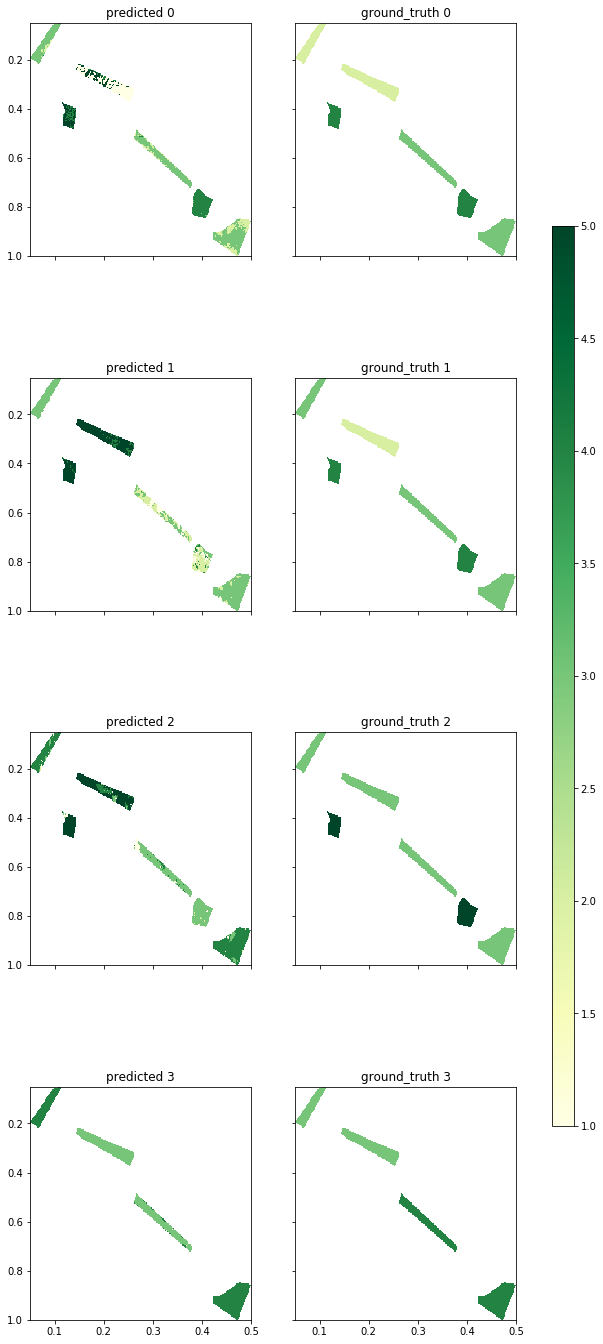

In [134]:

data_to_plot = []#[predicted, test]
tags = []#['predicted', 'ground_truth']

for time in [0,1,2,3]:
    predicted = xarr.isel(time=time)['predict']
    test = xarr.isel(time=time)['test']
    data_to_plot += [predicted, test]
    tags += ['predicted '+str(time), 'ground_truth '+str(time)]


fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 25), sharex=True, sharey=True)
for idx, ax in enumerate(axes.flat):
    im = ax.imshow(data_to_plot[idx], cmap='YlGn',
     vmin=1, vmax=5, extent=[0.05,0.5,1,0.05],aspect=0.5)
    ax.set_title(tags[idx])

fig.subplots_adjust(right=0.8)
# put colorbar at desire position
cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
fig.colorbar(im, cax=cbar_ax)

TypeError: colorbar() missing 1 required positional argument: 'mappable'

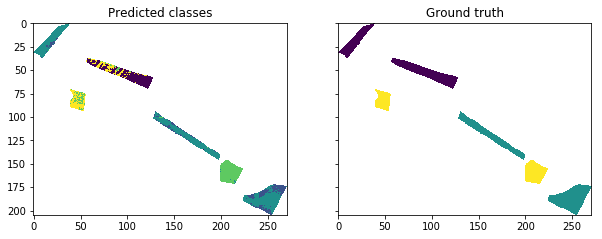

In [97]:
import matplotlib.pyplot as plt

#plt.imshow(predicted)
#plt.colorbar()
fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)
ax[0].imshow(predicted)
ax[0].set_title('Predicted classes')
ax[1].imshow(test)
ax[1].set_title('Ground truth')
fig.colorbar()#ax[0], ax=ax[0])
for a in ax.ravel():
    a.set_axis_off()
plt.tight_layout()
plt.show()

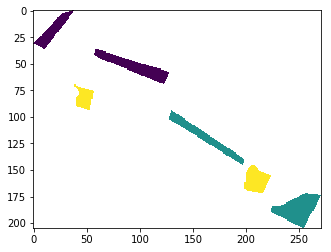

In [84]:
plt.imshow(test)

In [48]:
# Concatenate into one xarray
dimnames = xr.Variable('band', pd.Index(['class', 'predict']))
da = xr.concat([original.where(original>0).drop('class_mask'), predicted], dimnames)

In [49]:
da

<xarray.DataArray 'class' (band: 2, x: 2979, y: 3631)>
dask.array<shape=(2, 2979, 3631), dtype=float64, chunksize=(1, 2979, 3631)>
Coordinates:
  * y        (y) float64 4.122e+05 4.122e+05 4.122e+05 4.122e+05 4.122e+05 ...
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * band     (band) object 'class' 'predict'

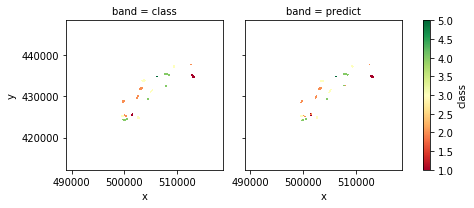

In [50]:
# Plot
da.plot(x='x', y='y', col='band', vmin=1., vmax=5., cmap='RdYlGn')

In [51]:
# Test merging into dataset
merged = xr.merge([original, predicted])
merged

<xarray.Dataset>
Dimensions:     (x: 2979, y: 3631)
Coordinates:
  * y           (y) float64 4.122e+05 4.122e+05 4.122e+05 4.122e+05 ...
  * x           (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
    class_mask  (x, y) bool dask.array<shape=(2979, 3631), chunksize=(2979, 3631)>
Data variables:
    class       (x, y) uint8 dask.array<shape=(2979, 3631), chunksize=(2979, 3631)>
    predict     (x, y) float64 nan nan nan nan nan nan nan nan nan nan nan ...

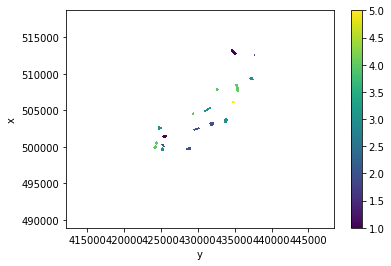

In [52]:
merged['class'].where(merged.class_mask).plot()

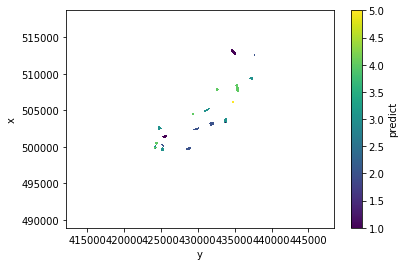

In [53]:
merged['predict'].plot()

In [135]:
# Close h2o cluster
h2o.cluster().shutdown(prompt=False)

H2O session _sid_9afd closed.


## Rest of h2o.ai tutorial

In [25]:
# Import H2O RF:
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [26]:
# Initialize the RF estimator:

rf_fit1 = H2ORandomForestEstimator(model_id='rf_fit1', seed=1)

In [27]:
rf_fit1.train(x=x, y=y, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [28]:
rf_fit2 = H2ORandomForestEstimator(model_id='rf_fit2', ntrees=100, seed=1)
rf_fit2.train(x=x, y=y, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [29]:
rf_perf1 = rf_fit1.model_performance(test)
rf_perf2 = rf_fit2.model_performance(test)

In [30]:
print rf_perf1.auc()
print rf_perf2.auc()

0.663462768485
0.669287987873


In [31]:
rf_fit3 = H2ORandomForestEstimator(model_id='rf_fit3', seed=1, nfolds=5)
rf_fit3.train(x=x, y=y, training_frame=data)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [32]:
print rf_fit3.auc(xval=True)

0.663606041745


In [33]:
# Import H2O GBM:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [34]:
# Initialize and train the GBM estimator:

gbm_fit1 = H2OGradientBoostingEstimator(model_id='gbm_fit1', seed=1)
gbm_fit1.train(x=x, y=y, training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [35]:
gbm_fit2 = H2OGradientBoostingEstimator(model_id='gbm_fit2', ntrees=500, seed=1)
gbm_fit2.train(x=x, y=y, training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [36]:
gbm_fit3 = H2OGradientBoostingEstimator(model_id='gbm_fit3', 
                                        ntrees=500, 
                                        score_tree_interval=5,     #used for early stopping
                                        stopping_rounds=3,         #used for early stopping
                                        stopping_metric='AUC',     #used for early stopping
                                        stopping_tolerance=0.0005, #used for early stopping
                                        seed=1)

# The use of a validation_frame is recommended with using early stopping
gbm_fit3.train(x=x, y=y, training_frame=train, validation_frame=valid)


gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [37]:
gbm_perf1 = gbm_fit1.model_performance(test)
gbm_perf2 = gbm_fit2.model_performance(test)
gbm_perf3 = gbm_fit3.model_performance(test)

In [38]:
# Retreive test set AUC
print gbm_perf1.auc()
print gbm_perf2.auc()
print gbm_perf3.auc()

0.683883128672
0.684086466361
0.684443511563


In [39]:
gbm_fit2.scoring_history()

Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2018-04-25 08:45:40,0.028 sec,0.0,0.3856346,0.4740298,0.5,1.0,0.8182546
,2018-04-25 08:45:40,0.128 sec,1.0,0.3837005,0.4691294,0.6577912,2.6832997,0.4006858
,2018-04-25 08:45:40,0.174 sec,2.0,0.3820620,0.4651166,0.6658294,2.7939915,0.3332492
,2018-04-25 08:45:40,0.221 sec,3.0,0.3806936,0.4618385,0.6685103,2.9710023,0.3447454
,2018-04-25 08:45:40,0.276 sec,4.0,0.3795380,0.4591170,0.6701132,2.9754401,0.3318046
---,---,---,---,---,---,---,---,---
,2018-04-25 08:45:43,3.795 sec,43.0,0.3677312,0.4317210,0.7124068,3.6410228,0.2975859
,2018-04-25 08:45:43,3.888 sec,44.0,0.3676187,0.4314625,0.7129225,3.6553764,0.3021722
,2018-04-25 08:45:44,3.989 sec,45.0,0.3674805,0.4311606,0.7134660,3.6649454,0.3023984
,2018-04-25 08:45:48,7.995 sec,226.0,0.3612902,0.4176954,0.7402357,4.2582264,0.2599471


In [40]:
# Import H2O DL:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

In [41]:
dl_fit1 = H2ODeepLearningEstimator(model_id='dl_fit1', seed=1)
dl_fit1.train(x=x, y=y, training_frame=train)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [42]:
dl_fit2 = H2ODeepLearningEstimator(model_id='dl_fit2', 
                                   epochs=20, 
                                   hidden=[10,10], 
                                   stopping_rounds=0,  #disable early stopping
                                   seed=1)
dl_fit2.train(x=x, y=y, training_frame=train)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [43]:
dl_fit3 = H2ODeepLearningEstimator(model_id='dl_fit3', 
                                   epochs=20, 
                                   hidden=[10,10],
                                   score_interval=1,          #used for early stopping
                                   stopping_rounds=3,         #used for early stopping
                                   stopping_metric='AUC',     #used for early stopping
                                   stopping_tolerance=0.0005, #used for early stopping
                                   seed=1)
dl_fit3.train(x=x, y=y, training_frame=train, validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [44]:
dl_perf1 = dl_fit1.model_performance(test)
dl_perf2 = dl_fit2.model_performance(test)
dl_perf3 = dl_fit3.model_performance(test)

In [45]:
# Retreive test set AUC
print dl_perf1.auc()
print dl_perf2.auc()
print dl_perf3.auc()

0.686254936726
0.681516110354
0.681802966019


In [47]:
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
nb_fit1 = H2ONaiveBayesEstimator(model_id='nb_fit1')
nb_fit1.train(x=x, y=y, training_frame=train)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


In [48]:
nb_fit2 = H2ONaiveBayesEstimator(model_id='nb_fit2', laplace=6)
nb_fit2.train(x=x, y=y, training_frame=train)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


In [49]:
nb_perf1 = nb_fit1.model_performance(test)
nb_perf2 = nb_fit2.model_performance(test)

In [50]:
# Retreive test set AUC
print nb_perf1.auc()
print nb_perf2.auc()

0.651337099516
0.651391851824
